# Legionella example 

*Nabil-Fareed Alikhan* 

This is a walkthrough of how to go from start to finish of generating a tree for a simple dataset.

The dataset is available here: 
https://github.com/quadram-institute-bioscience/datasets/blob/master/datasets/PA_76_benchMarkInfo.tsv

and there is a paper describing it: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5042515/



# The dataset 


# Get the reads and reference
FASTQ Dump is one way to do it. 

fastq-dump is part of the SRA toolkit; get via conda with:
```
conda install -c bioconda sra-tool
```

Then to get the reads themselves:
```
fastq-dump --gzip --split-files -v SRR3613186
fastq-dump --gzip --split-files -v SRR3613187
fastq-dump --gzip --split-files -v SRR3613188
fastq-dump --gzip --split-files -v SRR3613189
fastq-dump --gzip --split-files -v SRR3613181
fastq-dump --gzip --split-files -v SRR3613183
```

Choosing a reference is a task in of itself, but there's one suggested in the intial data table anyway, so just download that from https://www.ncbi.nlm.nih.gov/assembly/GCF_001752765.1/


# Doing the analysis 

I find that I wil wind up running trees a couple of times before I am happy with them. e.g. run once, remove tips, run again, change reference, run a third time, happy. 

It therefore make sense to have a structured workflow that I can easily tweak and re-run. 
For that I use nextflow for bigger tasks, and galaxy if it's small and I am in a hurry. 

Nextflow example follows. I run: 
```
nextflow run ~/code/nf-bigtree/filelist.nf    --filelist filelist.full.csv --reference /home/ubuntu/scratch/leg_test_tree/LEG.fna --tree true -resume
```
Where filelist.nf is :

```
#!/usr/bin/env nextflow
params.reads = "/hpc-home/alikhan/test_reads"
params.reference = "/hpc-home/alikhan/Informatics/alikhan/ref/LT2.fna"
params.filelist  = 'filelist.full.csv'

Channel.fromPath( params.filelist ).splitCsv( header:true ).map{ row-> tuple(row.name, file(row.r1), file(row.r2)) }.set { reads_snippy }
ref = file(params.reference)
params.tree = false

process snippy {
   cpus 8

   input:
   set name, file(read1), file(read2) from reads_snippy
   file ref

   output:
   file "${name}" into core_aln_results

   script:
   """
   snippy --cpus ${task.cpus} --ref ${ref} --R1 ${read1} --R2 ${read2} --outdir ${name} --cleanup
   """
}

process snippycore {
    publishDir 'snippy', mode: 'copy', overwrite: true
    cpus 10

    input:
    file(snippy) from core_aln_results.collect()

    output:
    file "core.full.aln" into snipclean
    file "core*" into snippyout

    script:
    """
    snippy-core --mask-char=N --ref ${params.reference} ${snippy}
    """
}

process snippyclean {
    publishDir 'snippy', mode: 'copy', overwrite: true

    input:
    file(core) from snipclean

    output:
    file "clean.full.aln" into ( iq_align, nj_core_align, ft_core_align, clonal_align, fast_align)

    script:
    """
    snippy-clean_full_aln ${core} > clean.full.aln
    """
}


process rapidnj  {
    publishDir 'rapidnj', mode: 'copy', overwrite: true

    input:
    file core from nj_core_align

    output:
    file 'rapidnj.tree' into njtree

    script:
    """
    rapidnj -n -i fa ${core} > rapidnj.tree
    """
}

process iqtree{
   cpus 8
   publishDir 'iqtree', mode: 'copy', overwrite: true

   when:
   params.tree

   input:
   file align from iq_align

   output:
   file 'iqtree*' into iqout
   file 'iqtree.treefile' into iqtreeout

   script:
   """
   iqtree -s ${align} -pre iqtree -nt ${task.cpus} -m GTR+G
   """
}
```

This runs snippy, rapidnj (neighbour joining tree), IQTree and chains them one after the other. Nextflow allows me to switch this to run this locally or via the HPC.

The important output from this is the tree from IQTREE.

```
IQ-TREE 2.0.3 built Dec 20 2020

Input file name: clean.full.aln
Type of analysis: tree reconstruction
Random seed number: 779459

REFERENCES
----------

To cite IQ-TREE please use:

Bui Quang Minh, Heiko A. Schmidt, Olga Chernomor, Dominik Schrempf,
Michael D. Woodhams, Arndt von Haeseler, and Robert Lanfear (2020)
IQ-TREE 2: New models and efficient methods for phylogenetic inference
in the genomic era. Mol. Biol. Evol., in press.
https://doi.org/10.1093/molbev/msaa015

SEQUENCE ALIGNMENT
------------------

Input data: 7 sequences with 3408562 nucleotide sites
Number of constant sites: 3.40537e+06 (= 99.9062% of all sites)
Number of invariant (constant or ambiguous constant) sites: 3.40537e+06 (= 99.9062% of all sites)
Number of parsimony informative sites: 3150
Number of distinct site patterns: 350

SUBSTITUTION PROCESS
--------------------

Model of substitution: GTR+F+G4

Rate parameter R:

  A-C: 1.0418
  A-G: 3.9840
  A-T: 0.6003
  C-G: 1.0110
  C-T: 3.6067
  G-T: 1.0000

State frequencies: (empirical counts from alignment)

  pi(A) = 0.3088
  pi(C) = 0.1908
  pi(G) = 0.1915
  pi(T) = 0.3089

Rate matrix Q:

  A   -0.8652      0.15    0.5754    0.1399
  C    0.2426    -1.229     0.146    0.8403
  G    0.9278    0.1455    -1.306     0.233
  T    0.1398    0.5191    0.1444   -0.8034

Model of rate heterogeneity: Gamma with 4 categories
Gamma shape alpha: 0.6957

 Category  Relative_rate  Proportion
  1         0.07327        0.25
  2         0.3615         0.25
  3         0.9233         0.25
  4         2.642          0.25
Relative rates are computed as MEAN of the portion of the Gamma distribution falling in the category.

MAXIMUM LIKELIHOOD TREE
-----------------------

Log-likelihood of the tree: -4661945.7491 (s.e. 650.1591)
Unconstrained log-likelihood (without tree): -5209901.2852
Number of free parameters (#branches + #model parameters): 20
Akaike information criterion (AIC) score: 9323931.4982
Corrected Akaike information criterion (AICc) score: 9323931.4984
Bayesian information criterion (BIC) score: 9324192.3342

Total tree length (sum of branch lengths): 0.0010
Sum of internal branch lengths: 0.0009 (99.0840% of tree length)

WARNING: 1 near-zero internal branches (<0.0000) should be treated with caution
         Such branches are denoted by '**' in the figure below

NOTE: Tree is UNROOTED although outgroup taxon 'Reference' is drawn at root

+**Reference
|
|                                      +**SRR3613181
|  +-----------------------------------|
|  |                                   +**SRR3613183
+--|
|  |                                                          +--SRR3613187
|  +----------------------------------------------------------|
|                                                             |  +--SRR3613188
|                                                             +**|
|                                                                +--SRR3613189
|
+**SRR3613186

Tree in newick format:

(Reference:0.0000000696,((SRR3613181:0.0000002840,SRR3613183:0.0000000293):0.0003602348,(SRR3613187:0.0000032773,(SRR3613188:0.0000023774,SRR3613189:0.0000026827):0.0000000293):0.0005845741):0.0000016289,SRR3613186:0.0000000293);

TIME STAMP
----------

Date and time: Thu Mar  4 13:10:16 2021
Total CPU time used: 6.237163 seconds (0h:0m:6s)
Total wall-clock time used: 0.85076113 seconds (0h:0m:0s)
```


## Aside: How do I manage installing software 

It is best to keep your installed software contained (in containers like docker/singularity or by using specific enviroments with conda)

There are ready made containers available for you to use like https://hub.docker.com/u/staphb
I like to embed the install process as part of the workflow.

If you add something like this to your nextflow configuration, when the workflow runs it will download the container and run. It can be cached for subsequent runs as well.   
In this example, it will have a 200 MB file that has snippy inside. 

```
        singularity {
            autoMounts = false
            enabled = true
            cacheDir = "/home/ubuntu/singularity/"
        }
        process {
            executor = 'local'
            withName:snippy {
               container = 'docker://staphb/snippy'
            }
```
            
Otherwise for other software you can have a conda environment. So for the other software I needed I just used conda to create a specific environment
``` conda env create --name tree iqtree rapidnj ```


# Drawing the tree

Software that you can use:

* iTOL
* Figtree
* Grapetree

Current visualisations tools sometimes do not give you the flexibility to get the figure you want. Lately I've been trying to get more comfortable with R using the ggtree package, as shown below. 

In [52]:
library(phangorn)
library(ggtree)
library(ggnewscale)
library(colorspace)
library(RColorBrewer)

## Load in data

In [53]:
tree <- read.tree("legionella.tree")
info <- read.csv("fake_meta.txt")
head(info)

,accession,place
,<fct>,<fct>
1,SRR3613181,a
2,SRR3613183,b
3,SRR3613186,c
4,SRR3613187,c
5,SRR3613188,d
6,SRR3613189,e


## Basic tree

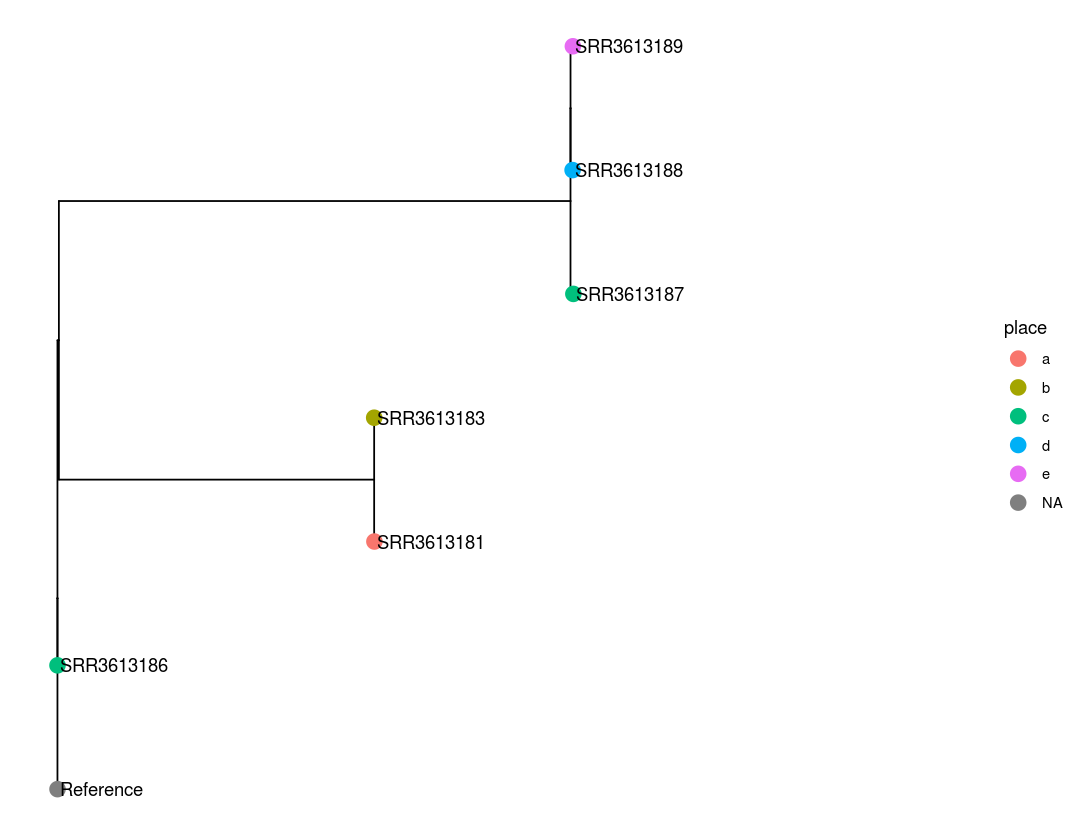

In [54]:
options(repr.plot.width=9, repr.plot.height=7) ; par(oma=c(0,0,0,0))

p <- ggtree(tree) %<+% info + geom_tippoint(aes(color=place), size=4) + geom_tiplab() + ggplot2::xlim(0, 0.001)
plot(p)